# Pointwise Image Operations

One of the simplest ways to transform an image is to apply a function to each pixel:

\\[O[i,j] = f(I[i,j])\\]

This is a “pointwise” operation: the output is the same size as the input, and each output pixel only depends on the input pixel at the same point.

The function \\(f\\) can do many things.  It can apply linear or affine transformations to the pixels (in the case of color, treating the RGB triples as 3-vectors), which are very useful for exposure and color adjustments.  Or it can be a componentwise nonlinear operation, where each of the the three color components in the output is a function of the corresponding color component in the input; this type of operation is useful for contrast and tone adjustments.

In this part of the assignment we will implement a simple pipeline for processing color images measured by an image sensor, similar to what you would find in your camera.  A digital photograph starts life as light measurements read out of an image sensor, which is just an array of photosensors, and digitized into an array of integers, each measuring the response of one color channel of one pixel to the light falling on it.  The photosensors are linear devices, so the number at a pixel increases linearly with the number of photons striking that pixel.

The steps in a camera processing pipeline to get from here to a decent image are:

* black level correction, which accounts for the nonzero signal the pixels produce even in complete darkness;
* color balancing, which corrects for the color of the light source so that there is no color cast; that is, a neutral gray maps to a neutral gray (a color with R=G=B);
* color correction, which transforms the R,G,B triples measured by the camera into R,G,B triples that will approximate the color that was measured by the camera; 
* tone mapping, which maps the rather wide range of intensities observed by the camera to the narrower range achievable by the display, in such a way as to get a pleasing image with good contrast; and 
* gamma correction, which accounts for the nonlinear mapping that will be applied by the display in mapping from 8 bit values to actual displayed brightness.

All these steps are important to getting images that are as good as what we expect from any camera today.

First we import some familiar libraries, as well as the `tifffile` library that will let us read color images with 16-bit pixel values.

In [1]:
import numpy as np
from PIL import Image
from IPython.display import display
from ipywidgets import interact
import tifffile

We also provide implementations of the sRGB transfer function and its inverse.  The functions `from_srgb` and `to_srgb` operate on floating-point values in the range between 0 and 1, and `from_srgb8` and `to_srgb8` include the additional translation between floats in the range $[0,1]$ and integers in the range $[0,255]$.  They implement the transfer function defined by the [sRGB standard](https://en.wikipedia.org/wiki/SRGB#Specification_of_the_transformation), and you don't have to change them, but you should look at them to understand how they operate, since they provide good examples of how to implement pixelwise operations and datatype conversions efficiently in NumPy.

In [2]:
%matplotlib notebook
import matplotlib
from matplotlib import pyplot as plt

In [3]:
def from_srgb(img_srgb):
    return np.where(img_srgb > 0.04045, ((img_srgb + 0.055) / 1.055)**2.4, img_srgb / 12.92).astype(np.float32)

def to_srgb(img):
    img_clip = np.clip(img, 0, 1)
    return np.where(img > 0.0031308, (1.055 * img_clip**(1/2.4) - 0.055), 12.92 * img_clip)

def from_srgb8(img_srgb8):
    return from_srgb(img_srgb8 / 255.0)

def to_srgb8(img):
    return np.clip(np.round(255.0 * to_srgb(img)), 0, 255).astype(np.uint8)

## The raw image from the camera's sensor

Below is a raw image from a Canon 80D SLR, taken by the folks at [Imaging Resource](https://www.imaging-resource.com) as part of their camera evaluation process.  The only thing we have done besides converting the camera's propietary format to a standard one is to "demosaic" the image: as explained in the image I/O lecture, the  image sensor has separate red, green, and blue pixels, and we used the tool `dcraw` to interpolate the missing values as 16-bit unsigned integers.  We also converted to a more manageable resolution from the 20 megapixel original. 

Data type is uint16


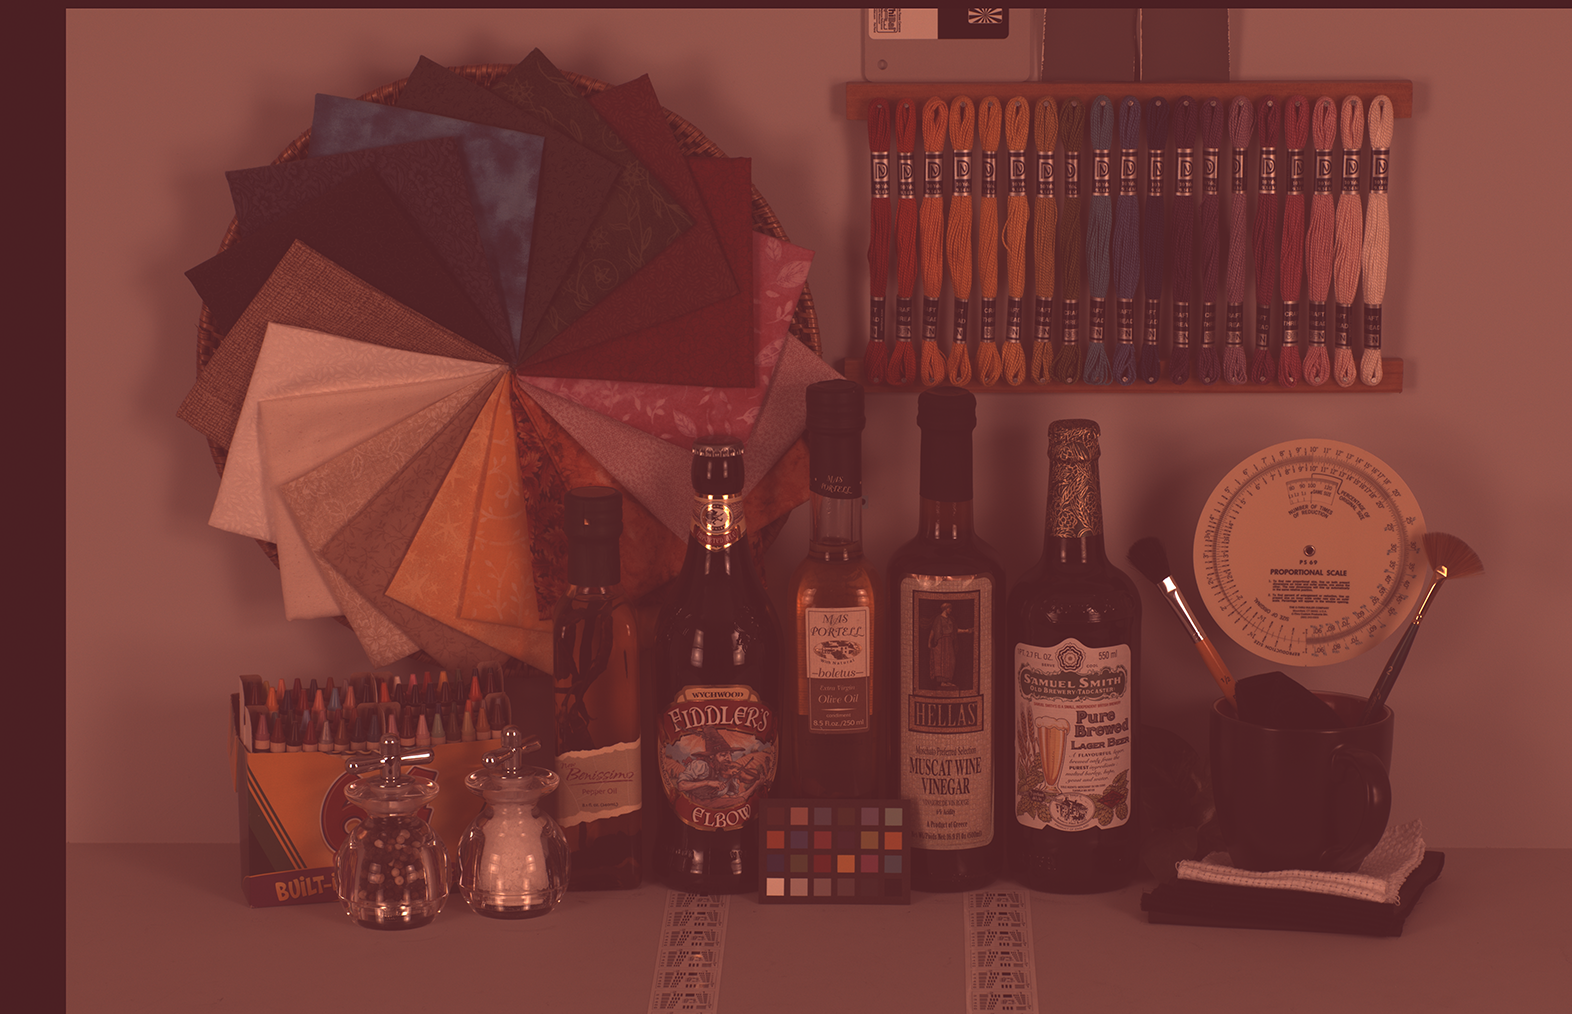

In [60]:
im = tifffile.imread('inputs/80DhSLI00400NR0-lr.tif')
print('Data type is', im.dtype)
display(Image.fromarray(np.clip(0, 255, (im / 256)).astype(np.uint8)))

Why did I divide by 256?

You can see that it's very dark but the highlights go up to the full range, and the highlights are far brighter than white diffuse objects are.  It also has a strong color cast due to the combination of camera sensor and illuminant color.

You can get a better look at this image if you multiply it by a scalar to brighten it, though be sure to clamp values that are trying to go out of range (`numpy.clip` is your friend).  When you do this you'll notice the parts of the image that ought to be black are actually far from zero.

To get a better idea of the numerical values, you can use Matplotlib to display the image; it gives you a pixel value readout when you mouse over the image, and also provides zooming and panning.  If you display one channel at a time it will display in pseudocolor, auto-scaled to the range of values present:

<IPython.core.display.Javascript object>


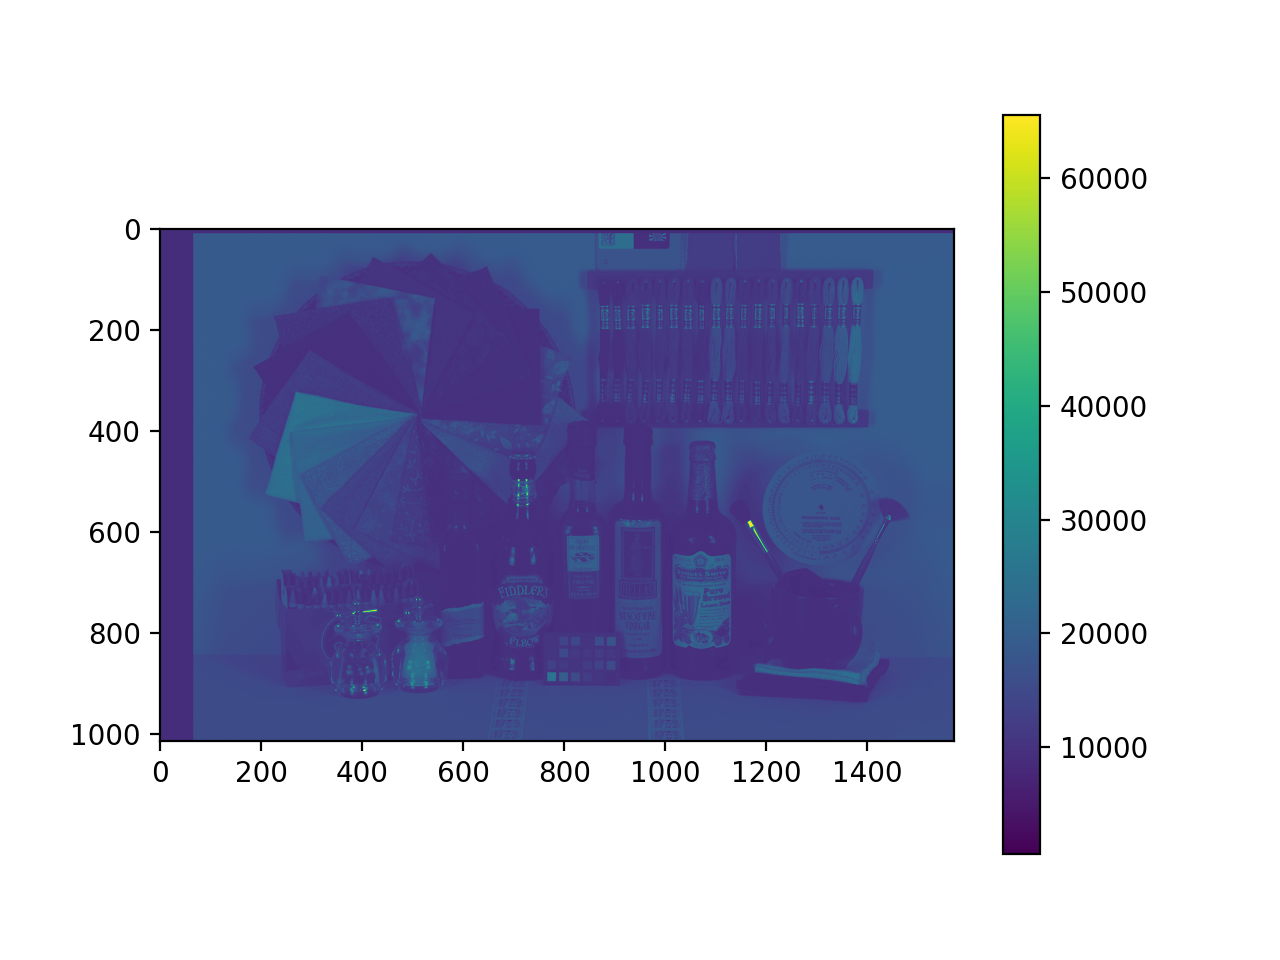

In [64]:
plt.figure()
plt.imshow(im[:,:,2])
plt.colorbar()

In fact that bar on the left is an area where the image sensor has pixels that are shielded from light so that you can see the sensor's response to complete darkness (called the black level).  It varies depending on exposure time, gain settings, ambient temperature, etc. so most sensors have an area like this so that camera software can correct for the particular black level for a given exposure.

Read out the R, G, B values (averages of an area are ideal but just typical values will work) to get a black level.

In [33]:
# fill in your values...
black_level = np.array([19316, 8196, 9042])

The other basic correction is white balancing: the RGB channels need to be scaled separately so that the colors are relative to the color of the light.  See the lecture on color constancy.  As explained in that lecture, the best way to do white balancing is to actually photograph a gray object and look at the pixel values.  The color chart in this image (the 24-square thing in the center bottom) has several gray chips in it.  Measure the pixel values from one of the middle ones, and use them to compute color balance factors to multiply the image.

In [34]:
# fill in your values...
gray = np.array([23036, 10304, 11432])

Now compute the white-balanced raw image by subtracting the black level and then scaling by your white balance factors.  Display it by scaling it by an appropriate exposure factor to map it to the range $[0,1]$ (a simple division should work, don't worry if you get values outside the range, these will be clipped later) and gamma correcting using the sRGB implementation above.

This produces an image that is starting to look reasonable; these two steps are by far the most important in getting a decent color image.  But the colors are still undersaturated because we are just displaying the raw sensor RGB as the display RGB, but these are not the same color space.

/Users/eleanorgoh/opt/anaconda3/envs/cgA3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


float32


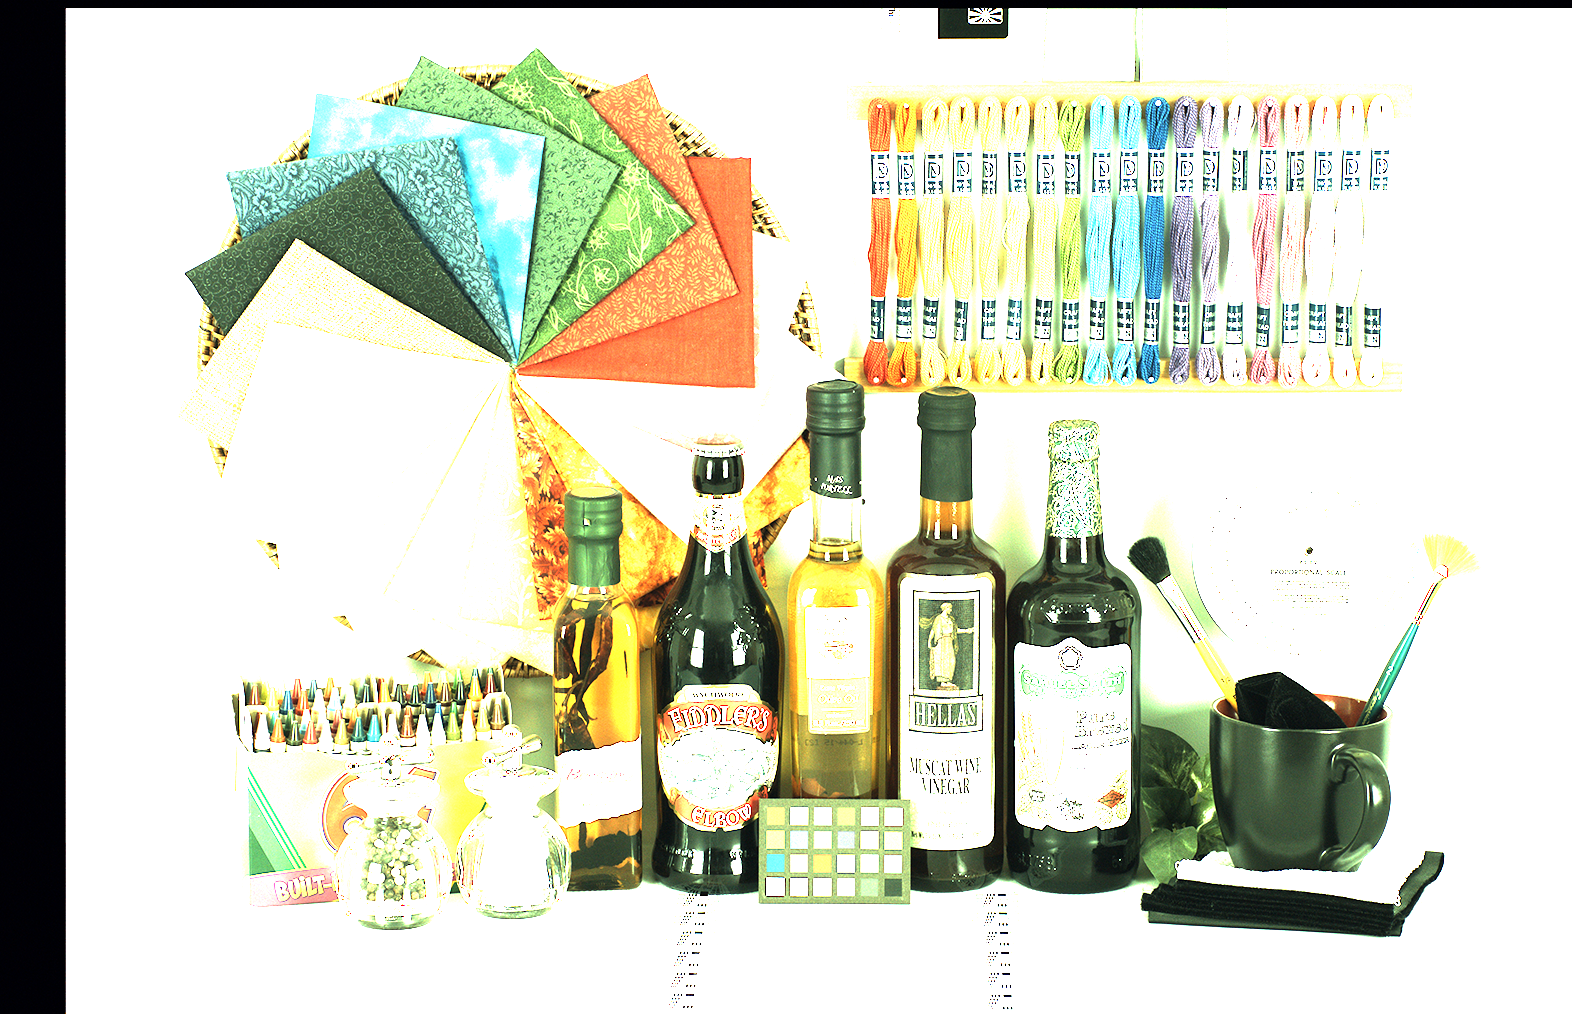

In [102]:
# ======================= white_balance =======================
# Input:
#   I: an RGB image -- a numpy array of shape (height, width, 3)
#   black_level: an RGB offset to be subtracted from all the pixels
#   gray: the RGB color of a gray object (includes the black level)
# Output:
#   The corrected image: 
#     * black level subtracted, then 
#     * color channels scaled to make gray come out gray, and
#     * full range of input image mapped to [0, 1]
#   The datatype of the result should be np.float32
def white_balance(I, black_level, gray):
    # A3TODO: Complete this function
    I = (I - black_level) / (gray - black_level)
    return from_srgb(I) # Replace this with your implementation

balanced_im = white_balance(im, black_level, gray)
print(balanced_im.dtype)
linear_exposure = 1  # choose a better value!
display(Image.fromarray(to_srgb8(linear_exposure * balanced_im)))

## Color matrix

You may notice the image seems a bit undersaturated; the colors are kind of dingy and grayish.  This is because we are simply mapping the responses of the three color sensors in the camera pixels to the three channels of the display, which will indeed result in red objects coming out red, etc., but it does not get the colors actually correct.  As an example, imagine re-photographing the displayed image with the same camera; the red sub pixels in the display will produce a lot of response in the camera’s red channel, but also some response in the green and blue channels.  The same is true of green and blue.  So if we displayed any particular color on the screen and photographed it, we would generally get a less saturated color.  But this process is linear, and amenable to be modeled by a linear transformation and inverted.

One doesn’t normally do this by photographing screens (for various good reasons); rather it is typically done by photographing a standard chart like the one in this image, which has exactly known colors (i.e. the display RGB values that will match the colors on the chart are published), and finding a matrix that maps those colors as close as possible to the correct values.

We did that for you in this case; the matrix $M$ below has the properties:

* $M$ preserves neutral colors (so as not to disturb the color balance you just achieved).  That is, 

\\[M \begin{bmatrix}1\\1\\1\end{bmatrix} = \begin{bmatrix}1\\1\\1\end{bmatrix}\\]

* $M$ maps the 24 colors in this image to the 24 known correct color values, in a least-squares sense.

In [ ]:
M = np.array([
    [ 1.81716189, -0.99235485,  0.17519296],
    [-0.26792246,  1.82434515, -0.55642269],
    [ 0.00268803, -0.57656256,  1.57387453]
])

In [ ]:
M @ [1,1,1]

Write a function to apply this matrix to each RGB triple in an image.

In [ ]:
# ======================= color_transform =======================
# Input:
#   I: an RGB image -- a numpy array of shape (height, width, 3)
#   M: a 3x3 matrix, to be multiplied with each RGB triple in I
# Output:
#   The image with each RGB triple multiplied by M
def color_transform(I, M):
    
    # A3TODO: Complete this function
    return I # Replace this with your implementation

When you use this function to apply the matrix to the color balanced image, you should see that the color saturation of the image is increased considerably, and the result is starting to be a nice looking image.

In [ ]:
corrected_im = color_transform(balanced_im, M)
linear_exposure = 1  # choose a better value!
display(Image.fromarray(to_srgb8(linear_exposure * corrected_im)))

## Tone mapping

We now have a pretty accurate image.  If you play with the exposure you can get a pleasantly bright image that doesn’t clip off the bright areas too much.  But it’s still a little flat compared to the image the real camera produces, and it’s hard to get it nice and bright without losing some of the lightest colors (and particularly the shiny reflections of the light sources) to clipping.

The problem of how best to map the intensities of the world to the intensities of the display is part science and part art.  Suffice it to say that the makers of cameras and film have been solving this problem for many decades, and what we tend to do in modern computer graphics is to just imitate that.  There are many tone mapping curves that have been proposed, and many that are called “filmic” to indicate that they are trying to look like film ... or really, trying to get a look that resembles what modern digital cameras do.

We picked one of these and included an implementation; it is a simplified fit by Krzysztof Narkowicz to a tone mapping function recommended by the Academy of Motion Picture Arts and Sciences in its ACES standard.  It is meant to be applied separately to the R, G, and B values of each pixel.  Try it!  (There's not much to ask you to implement here, since it's a strictly componentwise operation.)

In [ ]:
def ACES_filmic(x):
    a = 2.51;
    b = 0.03;
    c = 2.43;
    d = 0.59;
    e = 0.14;
    return np.clip((x*(a*x+b))/(x*(c*x+d)+e), 0, 1)

In [ ]:
plt.figure(figsize=(9,4))
x = np.linspace(0,4,501)
plt.plot(x, ACES_filmic(x))
plt.xlabel('scene radiance value')
plt.ylabel('displayed pixel value');

You will find it increases contrast and initially loses a bit more of the highlights than you might want; typically with this curve you end up wanting a bit lower exposure.  But once you adjust it you will find you get more contrast and can keep a little more detail in the highlights without making the image too dark overall.

In [ ]:
filmic_exposure = 1  # choose a better value!
tonemapped_im = corrected_im   # replace with your implementation
display(Image.fromarray(to_srgb8(tonemapped_im)))

Here is a cell to compare the linear and filmic approaches to tone mapping.  The filmic approach makes a tradeoff of increasing overall image contrast and decreasing the flatness of highlights in exchange for losing some detail in the light tones and in the very dark shadows.

In [ ]:
interact(lambda tone_curve: display(Image.fromarray(to_srgb8(
    {0:linear_exposure * corrected_im, 1:tonemapped_im}[tone_curve]
))), tone_curve=[('linear', 0), ('filmic', 1)]);